# Detection for Alzheimer's patients vs Frontotemporal dementia patients via various methods:

<span style='color:red'> OUTLINE <span>

1) Using "only" spectral connectivity features of 5 many quadraples of homotopic nodes with a single frequency band with long epoch lengths.
       
   <span style='color:red'> Conclusion: best training accuracy-validation accuracy pair (%83, %49)
    

2) Using "only" spectral connectivity features of all 19 nodes with all frequency bands with long epoch lengths.
       
   <span style='color:red'> Conclusion: best training accuracy-validation accuracy pair (%100, %76)
       

3) Using "both" the combination of rbps analysis of 15 nodes (4 nodes removed) with long epoch lengths and spectral connectivity features of 5 many quadraples of homotopic nodes with a single frequency band with long epoch lengths.
       
   <span style='color:red'> Conclusion: best training accuracy-validation accuracy pair (%92.3,%54)
       
4) Using "both" the combination of rbps analysis of 15 nodes (4 nodes removed) with long epoch lengths and spectral connectivity features of all 19 nodes with all frequency bands with long epoch lengths.

   <span style='color:red'> Conclusion: best training accuracy-validation accuracy pair (%92.1,%54)

In [3]:
import numpy as np
from model_functions import *
from Classification_models_LOSO_2Class import *
import matplotlib.pyplot as plt

In [21]:
subject_data, freqs, targets = load_psds('all_psds_very_long.pickle')
test_labels = align_test_labels(classes=['A','F'])
featuress, targetss = remove_class(subject_data,targets,'C')
features, targets = remove_test(featuress,targetss,test_labels)
rbps = [relative_band_power(features[i],freqs,freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0]) 
        for i in range(len(features))]

# Method 1
Using "only" spectral connectivity features of 5 many quadraples of homotopic nodes with a single frequency band with long epoch lengths.
1) P3,P4,O1,O2 nodes for delta band 
2) C3,C4,F3,F4 nodes for theta band 
3) C3,C4,F3,F4 nodes for delta band 
4) C3,C4,T3,T4 nodes for theta band
5) C3,C4,P3,P4 nodes for theta band

Freq. Band: {"delta": [0.5, 4.0],
              "theta": [4.0, 8.0],
              "alpha": [8.0, 13.0],
              "beta": [13.0, 30.0]}

In [36]:
conn_data_1 = np.load('con_data_01.npy',allow_pickle=True)
conn_data_2 = np.load('con_data_02.npy',allow_pickle=True)
conn_data_3 = np.load('con_data_03.npy',allow_pickle=True)
conn_data_4 = np.load('con_data_04.npy',allow_pickle=True)
conn_data_5 = np.load('con_data_05.npy',allow_pickle=True)

In [37]:
def my_remove_test(features,test):
    features_train = [features[i] for i in range(len(features)) if i not in test]
    return features_train
def remove_test_targets(targets, test):
    target_train = [targets[i] for i in range(len(targets)) if i not in test]
    return target_train

test= [4,6,8,20,33,71,72]
cn_list= [i for i in range(38,67)]

In [38]:
len(np.append(test,cn_list))

36

In [39]:
data_1 = my_remove_test(conn_data_1, np.append(test,cn_list))
data_2 = my_remove_test(conn_data_2,np.append(test,cn_list))
data_3 = my_remove_test(conn_data_3,np.append(test,cn_list))
data_4 = my_remove_test(conn_data_4,np.append(test,cn_list))
data_5 = my_remove_test(conn_data_5, np.append(test,cn_list))

In [40]:
targets= np.array(targets)

52

In [41]:
data_1 = [data_1[i] for i in range(52)]
data_2 = [data_2[i] for i in range(52)]
data_3 = [data_3[i] for i in range(52)]
data_4 = [data_4[i] for i in range(52)]
data_5 = [data_5[i] for i in range(52)]

all_data = [data_1,data_2,data_3,data_4,data_5]

In [42]:
def get_arr(data, idx , epoch): 
    trials = [(data[idx][epoch].reshape(-1,))[i] for i in range(16) if (data[idx][epoch].reshape(-1,))[i] != 0]
    m = len(trials)
    return (np.array(trials)).reshape((1,m))

def get_all_freq_arr(all_data,idx, epoch):
    r = get_arr(all_data[0], idx , epoch)
    for i in range(1,len(all_data)):
        r = np.concatenate((r,get_arr(all_data[i], idx , epoch)),axis =1)
        
    #r=np.concatenate((get_arr(all_data[0], idx , epoch),get_arr(all_data[1], idx , epoch),get_arr(all_data[2], idx , epoch),get_arr(all_data[3], idx , epoch),get_arr(all_data[4], idx , epoch)), axis=1)
    return r

def get_all_epochs_data(all_data,idx):
    r = get_all_freq_arr(all_data,idx,0)
    for j in range(1,len(all_data[0][idx])):
        r = np.concatenate((r,get_all_freq_arr(all_data,idx,j)),axis = 0)
    return r   

def get_all_features(all_data):
    output_array = [];
    for j in range(len(all_data[0])):
        r = get_all_epochs_data(all_data,j)
        output_array = output_array + [r]
    return output_array

#the following is from the train_prep code from model_functions.npy
def train_prep(features,targets,exclude=None,flatten_final=True):
    total_subjects = len(targets)
    target_list = []
    for i in range(total_subjects):
        num_epochs = features[i].shape[0]
        target_list.append(targets[i]*np.ones(num_epochs))
    if exclude==None: 
        features_array = np.concatenate(features)
        targets_array = np.concatenate(target_list)
    else:
        features_array = np.concatenate(features[:exclude] + features[exclude+1:])
        targets_array  = np.concatenate(target_list[:exclude] + target_list[exclude+1:])
    if flatten_final:
        features_array = features_array.reshape((features_array.shape[0],-1))
    return features_array, targets_array

def kNN_cross(features,targets,n_neighbors, PCA_components = 0):
   
    confusion_matrices_train = []
    confusion_matrices_test = []
    labels = np.unique(targets)
    for i in range(len(targets)):
        train_X, train_y = train_prep(features,targets,exclude=i,flatten_final=True)
        test_X = features[i].reshape(features[i].shape[0],-1)
        test_y = targets[i]*np.ones(features[i].shape[0])

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
        if PCA_components != 0:
            pca = PCA(n_components = PCA_components)
            train_X = pca.fit_transform(train_X, y = None)
            test_X = pca.transform(test_X)
        
        ThreeNN = KNeighborsClassifier(n_neighbors=n_neighbors)
        ThreeNN.fit(train_X, train_y)
        labels=[1,2]
        confusion_matrices_train += [confusion_matrix(train_y, ThreeNN.predict(train_X),labels=labels)]
        confusion_matrices_test += [confusion_matrix(test_y,ThreeNN.predict(test_X),labels=labels)]
    
    confusion_matrices_train = np.array(confusion_matrices_train)
    confusion_matrices_test = np.array(confusion_matrices_test)
    total_confusion_train = np.sum(confusion_matrices_train, axis= 0)
    total_confusion_test = np.sum(confusion_matrices_test, axis= 0)
    
    train_metrics_dict = {'acc':accuracy(total_confusion_train), 'sens':sensitivity(total_confusion_train), 
                            'spec':specificity(total_confusion_train), 'f1':f1(total_confusion_train)}
    test_metrics_dict = {'acc':accuracy(total_confusion_test), 'sens':sensitivity(total_confusion_test), 
                            'spec':specificity(total_confusion_test), 'f1':f1(total_confusion_test)}
    
    
    return train_metrics_dict, test_metrics_dict


In [43]:
features = get_all_features(all_data)

In [44]:
kNN_cross(features, targets, n_neighbors=3, PCA_components = 0)

({'acc': 0.9985749346845064,
  'sens': 1.0,
  'spec': 0.9976982097186701,
  'f1': 0.9981327800829876},
 {'acc': 0.49663526244952894,
  'sens': 0.4558303886925795,
  'spec': 0.5217391304347826,
  'f1': 0.4082278481012658})

In [45]:
train_metric_dict, val_metric_dict = log_reg_cross(features, targets, PCA_components = 0, reg_parameter = 1)
train_metric_dict, val_metric_dict

({'acc': 0.8124719605204127,
  'sens': 0.6934109332779048,
  'spec': 0.8857203751065643,
  'f1': 0.7379986726642578},
 {'acc': 0.4993270524899058,
  'sens': 0.3321554770318021,
  'spec': 0.6021739130434782,
  'f1': 0.3357142857142857})

In [46]:
train_metric_dict, val_metric_dict = svm_cross(features, targets,kernel='linear',
                                               reg_parameter=100)
train_metric_dict, val_metric_dict

({'acc': 0.8354313461589211,
  'sens': 0.7692094505646782,
  'spec': 0.8761722080136403,
  'f1': 0.780731364275668},
 {'acc': 0.49663526244952894,
  'sens': 0.38869257950530034,
  'spec': 0.5630434782608695,
  'f1': 0.3703703703703704})

# Method 2
Using "only" spectral connectivity features of all 19 nodes with all frequency bands with long epoch lengths.

In [47]:
def get_arr(data, idx , epoch): 
    trials = [(data[idx][epoch].reshape(-1,))[i] for i in range(361) if (data[idx][epoch].reshape(-1,))[i] != 0]
    m = len(trials)
    return (np.array(trials)).reshape((1,m))


def get_all_freq_arr(all_data,idx, epoch):
    r = get_arr(all_data[0], idx , epoch)
    for i in range(1,len(all_data)):
        r = np.concatenate((r,get_arr(all_data[i], idx , epoch)),axis =1)
        
    #r=np.concatenate((get_arr(all_data[0], idx , epoch),get_arr(all_data[1], idx , epoch),get_arr(all_data[2], idx , epoch),get_arr(all_data[3], idx , epoch),get_arr(all_data[4], idx , epoch)), axis=1)
    return r

def get_all_epochs_data(all_data,idx):
    r = get_all_freq_arr(all_data,idx,0)
    for j in range(1,len(all_data[0][idx])):
        r = np.concatenate((r,get_all_freq_arr(all_data,idx,j)),axis = 0)
    return r

def get_all_features(all_data):
    output_array = [];
    for j in range(len(all_data[0])):
        r = get_all_epochs_data(all_data,j)
        output_array = output_array + [r]
    return output_array

In [48]:
conn_data_1 = np.load('con_data_19_delta.npy', allow_pickle=True)
conn_data_2 = np.load('con_data_19_theta.npy', allow_pickle=True)
conn_data_3 = np.load('con_data_19_alpha.npy', allow_pickle=True)
conn_data_4 = np.load('con_data_19_beta.npy',allow_pickle=True)
conn_data_5 = np.load('con_data_19_gamma.npy',allow_pickle=True)

data_1 = my_remove_test(conn_data_1, test)
data_2 = my_remove_test(conn_data_2,test)
data_3 = my_remove_test(conn_data_3, test)
data_4 = my_remove_test(conn_data_4,test)
data_5 = my_remove_test(conn_data_5, test)

data_1 = [data_1[i] for i in range(52)]
data_2 = [data_2[i] for i in range(52)]
data_3 = [data_3[i] for i in range(52)]
data_4 = [data_4[i] for i in range(52)]
data_5 = [data_5[i] for i in range(52)]

all_data = [data_1,data_2,data_3,data_4,data_5]

In [49]:
features = get_all_features(all_data)

In [50]:
train_metric_dict, val_metric_dict = log_reg_cross(features, targets, PCA_components = 0, reg_parameter = 1)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.7665816326530612,
  'sens': 0.7530864197530864,
  'spec': 0.7760869565217391,
  'f1': 0.7272727272727272})

In [51]:
kNN_cross(features, targets, n_neighbors=3, PCA_components = 0 )

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.7538265306122449,
  'sens': 0.8055555555555556,
  'spec': 0.717391304347826,
  'f1': 0.73006993006993})

In [52]:
kNN_cross(features, targets, n_neighbors=5, PCA_components = 15)

({'acc': 0.9981742697078831,
  'sens': 1.0,
  'spec': 0.9968883205456095,
  'f1': 0.9977959602669002},
 {'acc': 0.7206632653061225,
  'sens': 0.7530864197530864,
  'spec': 0.6978260869565217,
  'f1': 0.6902404526166902})

In [53]:
train_metric_dict, val_metric_dict = svm_cross(features, targets, kernel= "linear", reg_parameter = 1.0, degree=2, PCA_components= 0)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.7206632653061225,
  'sens': 0.6820987654320988,
  'spec': 0.7478260869565218,
  'f1': 0.6686838124054463})

In [54]:
train_metric_dict, val_metric_dict = svm_cross(features, targets,kernel='linear',
                                               reg_parameter=100)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.7206632653061225,
  'sens': 0.6820987654320988,
  'spec': 0.7478260869565218,
  'f1': 0.6686838124054463})

# Method 3
Using "both" the combination of rbps analysis of 15 nodes (4 nodes removed) with long epoch lengths and spectral connectivity features of 5 many quadraples of homotopic nodes with a single frequency band(delta or theta for a certain quadraples) with long epoch lengths.

In this analysis, we have the connectivity data of the following nodes:
1) P3,P4,O1,O2 nodes for delta band (6 entries in total)
2) C3,C4,F3,F4 nodes for theta band (6 entries in total)
3) C3,C4,F3,F4 nodes for delta band (6 entries in total)
4) C3,C4,T3,T4 nodes for theta band (6 entries in total)
5) C3,C4,P3,P4 nodes for theta band (6 entries in total)

which we joined with rbps data of 15 nodes(F3,F4,C4,F8 removed) on the frequency bands 0.5-4.0, 4.0-7.0, 7.0-9.0, 9.0-11.0, 11.0-13.0, 13.0-25.0 with (2 mins long epochs)very long epochs. 

In [55]:
features= np.load('rbp_plus_all_con_long_epochs.npy',allow_pickle=True)

In [56]:
#make sure to run targets as below if you didn't before above.
#features, targets = remove_class(subject_data,targets,'C')
#features, targets = remove_test(features,targets,test_labels)

In [57]:
def my_remove_test(features,test):
    features_train = [features[i] for i in range(len(features)) if i not in test]
    return features_train
def remove_test_targets(targets, test):
    target_train = [targets[i] for i in range(len(targets)) if i not in test]
    return target_train

test= [4,6,8,20,33,71,72]
cn_list= [i for i in range(38,67)]

In [58]:
len(np.append(test,cn_list))

36

In [60]:
data = my_remove_test(features, np.append(test,cn_list))

In [61]:
targets= np.array(targets)
len(targets)

52

In [62]:
kNN_cross(data,targets,n_neighbors=3, PCA_components = 0)

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.4508748317631225,
  'sens': 0.3003533568904594,
  'spec': 0.5434782608695652,
  'f1': 0.29411764705882354})

In [63]:
train_metric_dict, val_metric_dict = svm_cross(data, targets, kernel= "linear", reg_parameter = 1.0, degree=2, PCA_components= 0)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.4858681022880215,
  'sens': 0.26855123674911663,
  'spec': 0.6195652173913043,
  'f1': 0.2846441947565543})

In [64]:
train_metric_dict, val_metric_dict = svm_cross(data, targets, kernel= "linear", reg_parameter=0.085, PCA_components = 32)
train_metric_dict, val_metric_dict

({'acc': 0.9229409125696039,
  'sens': 0.9245479110372063,
  'spec': 0.9219522591645354,
  'f1': 0.9013780059443394},
 {'acc': 0.5437415881561238,
  'sens': 0.3568904593639576,
  'spec': 0.658695652173913,
  'f1': 0.3733826247689464})

In [66]:
train_metric_dict, val_metric_dict = log_reg_cross(data, targets)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.5006729475100942,
  'sens': 0.2862190812720848,
  'spec': 0.6326086956521739,
  'f1': 0.30393996247654786})

In [67]:
X, y = train_prep(data,targets,exclude=None,flatten_final=True)

In [68]:
pca = PCA()
pca.fit(X)
for i in range(35):
    channel, band = unroll(np.argmax(pca.components_[i]))
    print((CHANNELS[channel], band))

('O2', 18)
('T3', 15)
('F8', 30)
('T5', 42)
('O2', 40)
('P3', 28)
('O1', 41)
('O2', 39)
('Fp2', 18)
('O1', 41)
('Fp1', 27)
('T5', 36)
('T3', 39)
('P3', 43)
('Cz', 42)
('Fp2', 36)
('T5', 36)
('C3', 36)
('F7', 37)
('O1', 21)
('C4', 41)
('T5', 25)
('Fp1', 39)
('Fp2', 18)
('Pz', 38)
('P4', 38)
('Pz', 38)
('Fp2', 27)
('T4', 36)
('Fp2', 39)
('Fp2', 36)
('T5', 41)
('O2', 13)
('T5', 36)
('Cz', 38)


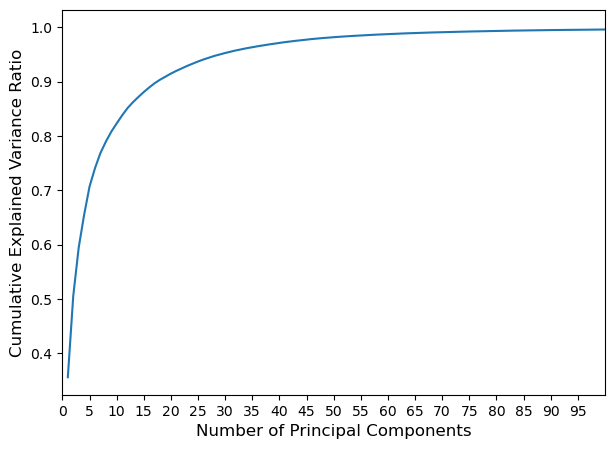

In [69]:
## make the explained variance curve
plt.figure(figsize=(7,5))


plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
            np.cumsum(pca.explained_variance_ratio_))

plt.ylabel("Cumulative Explained Variance Ratio", fontsize=12)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.xticks(range(0,100,5),fontsize=10)
plt.yticks(fontsize=10)

plt.xlim(0,100)

plt.show()

# Method 4
Using "both" the combination of rbps analysis of 15 nodes (4 nodes removed) with long epoch lengths and spectral connectivity features of all 19 nodes with all frequency bands with long epoch lengths.


In [70]:
features= np.load('con_data_19_plus_rbps_long_epoch.npy',allow_pickle=True)

In [71]:
#make sure to run targets as below if you didn't before above.
test= [4,6,8,20,33,71,72]

In [72]:
cn_list= [i for i in range(38,67)]

In [73]:
len(np.append(test,cn_list))

36

In [74]:
data = my_remove_test(features, np.append(test,cn_list))

In [75]:
targets= np.array(targets)
len(targets)

52

In [85]:
kNN_cross(data,targets,n_neighbors=3, PCA_components = 0)

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.4508748317631225,
  'sens': 0.3003533568904594,
  'spec': 0.5434782608695652,
  'f1': 0.29411764705882354})

In [77]:
train_metric_dict, val_metric_dict = svm_cross(data, targets, kernel= "linear", reg_parameter = 1.0, degree=2, PCA_components= 0)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.4858681022880215,
  'sens': 0.26855123674911663,
  'spec': 0.6195652173913043,
  'f1': 0.2846441947565543})

In [78]:
train_metric_dict, val_metric_dict = svm_cross(data, targets, kernel= "linear", reg_parameter=0.085, PCA_components = 32)
train_metric_dict, val_metric_dict

({'acc': 0.9228089620774286,
  'sens': 0.9242014827132267,
  'spec': 0.9219522591645354,
  'f1': 0.901192446711482},
 {'acc': 0.5410497981157469,
  'sens': 0.3568904593639576,
  'spec': 0.6543478260869565,
  'f1': 0.3720073664825046})

In [86]:
train_metric_dict, val_metric_dict = svm_cross(data, targets, kernel= "linear", reg_parameter=1.5, PCA_components = 45)
train_metric_dict, val_metric_dict

({'acc': 0.9987068851766817,
  'sens': 0.9982678583801011,
  'spec': 0.9989769820971867,
  'f1': 0.9983024424042957},
 {'acc': 0.5356662180349933,
  'sens': 0.2968197879858657,
  'spec': 0.6826086956521739,
  'f1': 0.32748538011695905})

In [79]:
train_metric_dict, val_metric_dict = log_reg_cross(data, targets)
train_metric_dict, val_metric_dict

({'acc': 1.0, 'sens': 1.0, 'spec': 1.0, 'f1': 1.0},
 {'acc': 0.5006729475100942,
  'sens': 0.2862190812720848,
  'spec': 0.6326086956521739,
  'f1': 0.30393996247654786})